In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from pathlib import Path
from contextlib import redirect_stdout

DATA_PATH = 'src/data/generated/clean_train.csv'
data = pd.read_csv(DATA_PATH).dropna()

pd.set_option('display.expand_frame_repr', False)

In [109]:
pathways = ['Cell_Cycle',
       'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53',
       'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2']

immune_cells = ['B cells naive', 'B cells memory', 'Plasma cells',
       'T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils']

all = ['Cell_Cycle',
       'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53',
       'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2','B cells naive', 'B cells memory', 'Plasma cells',
       'T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils']

recauen_2anys = data[(data['RFS']<730) & (data['RFSE'] == 1)]
recauen_2anys = recauen_2anys[pathways]
NOrecauen_5anys = data[(data['RFS']>1830) & (data['RFSE'] == 0)]
NOrecauen_5anys = NOrecauen_5anys[pathways]

In [104]:
class Correlation():

    def __init__(self, df1, df2, d=False):
        self.R2 = df1
        self.NR5 = df2

        self.corr1 = df1.corr()
        self.corr2 = df2.corr()
        self.diff_matrix = self.corr1-self.corr2
        self.abs_diff_matrix = np.absolute(self.corr1-self.corr2)

    def display(self, plot):
        if plot == "corr":
            plt.figure(figsize = (12,12))
            cmap = sns.color_palette("Spectral_r", as_cmap=True)
            mask = np.triu(np.ones_like(self.corr1, dtype=bool))
            sns.heatmap(self.corr1, cmap=cmap, vmax=1, vmin=-1,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Relapse in 2 years correlation matrix")
            plt.show()
            plt.figure(figsize = (12,12))
            cmap = sns.color_palette("Spectral_r", as_cmap=True)
            sns.heatmap(self.corr2, cmap=cmap, vmax=1, vmin=-1,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Do not relapse in 5 years correlation matrix")
            plt.show()
        if plot == "abs_diff":
            plt.figure(figsize = (12,12))
            cmap = sns.color_palette("rocket_r", as_cmap=True)
            mask = np.triu(np.ones_like(self.abs_diff_matrix, dtype=bool))
            sns.heatmap(self.abs_diff_matrix, mask=mask,cmap=cmap, vmin = 0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Correlation Absolute difference: abs(corr(R2)-corr(NR5))")
        if plot == "diff":
            plt.figure(figsize = (12,12))
            cmap = sns.color_palette("rocket_r", as_cmap=True)
            mask = np.triu(np.ones_like(self.diff_matrix, dtype=bool))
            sns.heatmap(self.diff_matrix, mask=mask,cmap=cmap, vmin = -1,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Correlation difference")
        if plot == "diff_overlap":
            plt.figure(figsize = (12,12))
            cmap = sns.color_palette("rocket_r", as_cmap=True)
            mask = np.triu(np.ones_like(self.diff_overlap_matrix, dtype=bool))
            sns.heatmap(self.diff_overlap_matrix, mask=mask,cmap=cmap, vmin = 0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

    def pairgrid(self, df, vars):
        plt.rcParams["axes.labelsize"] = 12
        g = sns.PairGrid(df[vars], diag_sharey=False)
        axes = g.axes
        g.map_upper(plt.scatter,  linewidths=1, 
                    edgecolor="w", s=90, alpha = 0.5)         
        g.map_diag(sns.kdeplot, lw = 4, legend=False)
        g.map_lower(sns.kdeplot, cmap="Blues_d")
        plt.show()

    def get_redundant_pairs(self, df):
        '''Get diagonal and lower triangular pairs of correlation matrix'''
        pairs_to_drop = set()
        cols = df.columns
        for i in range(0, df.shape[1]):
            for j in range(0, i+1):
                pairs_to_drop.add((cols[i], cols[j]))
        return pairs_to_drop

    def topNdiff(self, n=5):
        au_corr = self.abs_diff_matrix.unstack()
        labels_to_drop = self.get_redundant_pairs(self.R2)
        au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
        au_corr = au_corr[0:n]
        corr_R2 = []
        corr_NR5 = []
        confidence_intervals_var1 = []
        confidence_intervals_var2 = []
        overlap = []
        for i in range(len(au_corr)):
            vars = au_corr.index[i]
            corr_R2.append(self.corr1[vars[0]][vars[1]])
            corr_NR5.append(self.corr2[vars[0]][vars[1]])
            r1, p1, lo1, hi1 = self.pearson_corr(self.R2, vars[0], vars[1], alpha=0.1, show_info=False)
            confidence_intervals_var1.append([round(lo1,4), round(hi1,4)])
            r2, p2, lo2, hi2 = self.pearson_corr(self.NR5, vars[0], vars[1], alpha=0.1, show_info=False)
            confidence_intervals_var2.append([round(lo2,4), round(hi2,4)])
            start, end = self.overlap([lo1, hi1],[lo2, hi2])

            overlap_len = np.abs(end-start)
            total_len = np.abs(hi1-lo1) + np.abs(hi2-lo2) - overlap_len

            percentage_overlap = (overlap_len/total_len)*100
            overlap.append(round(percentage_overlap,2))
        
        data = {'Abs corr diff': au_corr,
                'corr_R2': corr_R2,
                'corr_NR5': corr_NR5,
                'CI Var1': confidence_intervals_var1,
                'CI Var2': confidence_intervals_var2,
                '% Overlap': overlap
        }

        df = pd.DataFrame(data, columns = ['Abs corr diff','corr_R2','corr_NR5','CI Var1','CI Var2','% Overlap'])
        df.to_csv('all.csv',sep=";")
        print(df)

    def pearson_corr(self, df, var1, var2, alpha, show_info):
        x = df[var1]
        y = df[var2]
        r, p = stats.pearsonr(x,y)
        r_z = np.arctanh(r)
        se = 1/np.sqrt(x.size-3)
        z = stats.norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo, hi = np.tanh((lo_z, hi_z))

        if show_info:
            print("--------------------------------")
            print("\n     Pearson's correlation       \n ")
            print("--------------------------------")
            print("corr = " + str(r))
            print("p-value = " + str(p))

            print("\n" + str(int((1-alpha)*100)) + " percent confidence interval:")

            print("[" + str(lo) + " , " + str(hi) + "]")
        return r, p, lo, hi

    def overlap(self, interval1, interval2):
        """
        Given [0, 4] and [1, 10] returns [1, 4]
        """
        if interval2[0] <= interval1[0] <= interval2[1]:
            start = interval1[0]
        elif interval1[0] <= interval2[0] <= interval1[1]:
            start = interval2[0]
        else:
            return (0, 0)

        if interval2[0] <= interval1[1] <= interval2[1]:
            end = interval1[1]
        elif interval1[0] <= interval2[1] <= interval1[1]:
            end = interval2[1]
        else:
            return (0, 0)

        return (start, end)

    def CI(self, var1='Hypoxia', var2='ERBB2', alpha=0.1, show_info=False):
        r1, p1, lo1, hi1 = self.pearson_corr(self.R2, var1, var2, alpha, show_info)
        r2, p2, lo2, hi2 = self.pearson_corr(self.NR5, var1, var2, alpha, show_info)
        
        start, end = self.overlap([lo1, hi1],[lo2, hi2])

        overlap_len = np.abs(end-start)
        total_len = np.abs(hi1-lo1) + np.abs(hi2-lo2) - overlap_len

        percentage_overlap = (overlap_len/total_len)*100
        percentage_overlap = str(round(percentage_overlap,2))+ '%'
        
        fig1, ax1 = plt.subplots() 
        ax1.set_ylim(0.5, 2.5)
        plt.suptitle(str(int((1-alpha)*100)) + "% Confidence Interval \n", y=1.05, fontsize=13)
        plt.title(var1 + " - " + var2, fontsize=12)

        plt.yticks(ticks=[1,1.5,2], labels=["Relapse 2 years","Overlap %","No Relapse 5years"])
        plt.vlines(hi1, ymin=0.85, ymax=1.15)
        plt.text(hi1-0.02, 0.70, str(round(hi1,2)), fontsize=10)
        plt.vlines(hi2, ymin=1.85, ymax=2.15)
        plt.text(hi2-0.02, 1.70, str(round(hi2,2)), fontsize=10)
        plt.vlines(lo1, ymin=0.85, ymax=1.15)
        plt.text(lo1-0.02, 0.70, str(round(lo1,2)), fontsize=10)
        plt.vlines(lo2, ymin=1.85, ymax=2.15)
        plt.text(lo2-0.02, 1.70, str(round(lo2,2)), fontsize=10)
        plt.hlines(1, xmin=lo1, xmax=hi1)
        plt.hlines(2, xmin=lo2, xmax=hi2)
        plt.text(r1, 1.2, "r : " + str(round(r1,2)), fontsize=12)
        plt.plot(r1, 1, 'bo')
        plt.text(r2, 2.2, "r : " + str(round(r2,2)), fontsize=12)
        plt.plot(r2, 2, 'bo')
        plt.barh(1.5, width=end-start, height=1,left=start, color = 'lavender')
        plt.text(((end+start)/2)-0.02, 1.5, percentage_overlap)

    def diff_overlap(self):
        features = ['Cell_Cycle',
       'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53',
       'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2','B cells naive', 'B cells memory', 'Plasma cells',
       'T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils']
features = ['Cell_Cycle',
       'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53',
       'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2','B cells naive', 'B cells memory', 'Plasma cells',
       'T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils']

        self.diff_overlap_matrix = pd.DataFrame(index=features, columns=features)
        self.diff_overlap_matrix = self.diff_overlap_matrix.fillna(0)
        
        for row, feature_row in enumerate(features): 
            for column, feature_column in enumerate(features): 
                if (row > column): 
                    r1, p1, lo1, hi1 = self.pearson_corr(self.R2, feature_row, feature_column, alpha=0.1, show_info=False)
                    r2, p2, lo2, hi2 = self.pearson_corr(self.NR5, feature_row, feature_column, alpha=0.1, show_info=False)
        
                    start, end = self.overlap([lo1, hi1],[lo2, hi2])

                    overlap_len = np.abs(end-start)
                    total_len = np.abs(hi1-lo1) + np.abs(hi2-lo2) - overlap_len

                    percentage_overlap = (overlap_len/total_len)*100

                    self.diff_overlap_matrix.loc[feature_row,feature_column] = percentage_overlap
        plt.figure(figsize = (12,12))
        cmap = sns.color_palette("rocket", as_cmap=True)
        mask = np.triu(np.ones_like(self.diff_overlap_matrix, dtype=bool))
        sns.heatmap(self.diff_overlap_matrix, mask=mask,cmap=cmap, vmin = 0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("% Overlap")

In [105]:
correlation = Correlation(recauen_2anys,NOrecauen_5anys)

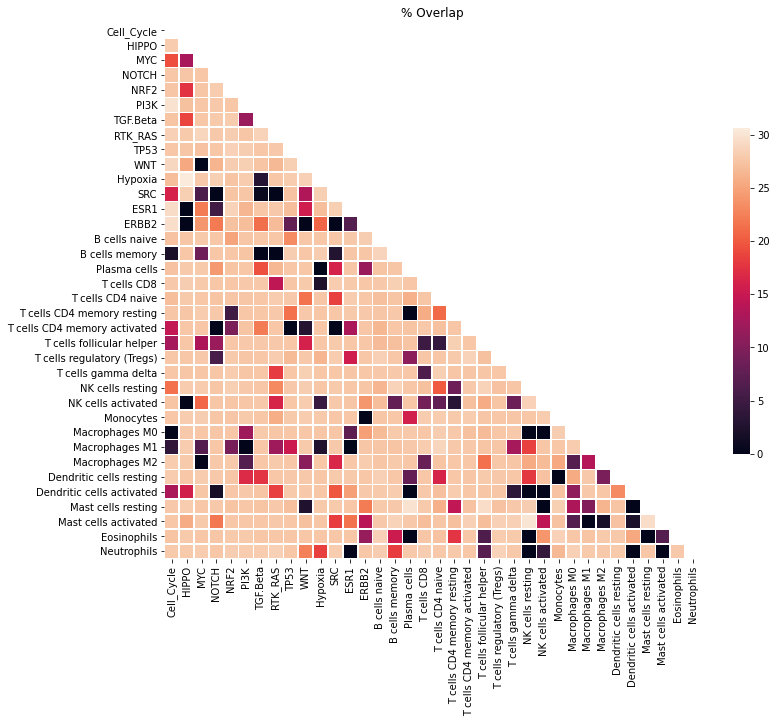

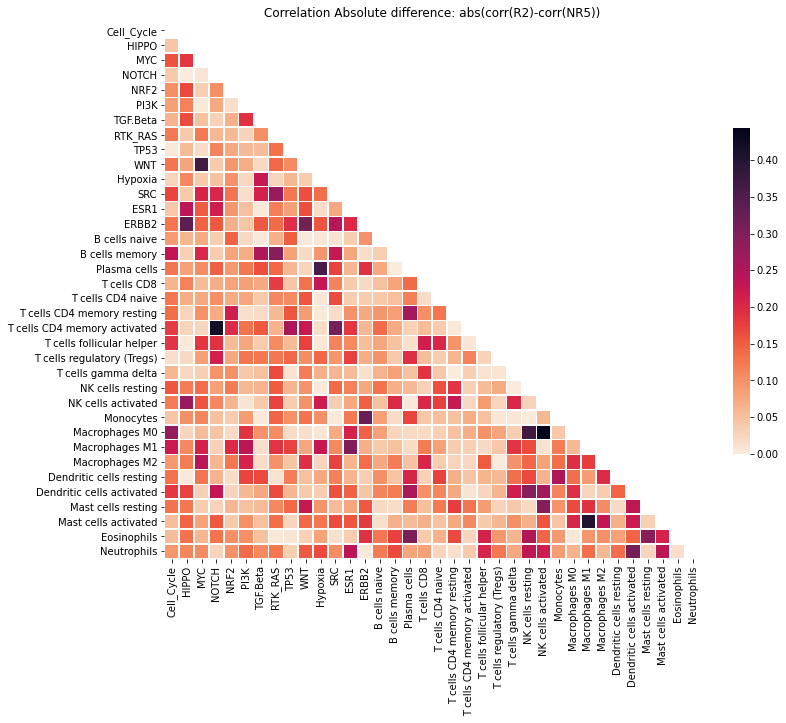

In [101]:
correlation.diff_overlap()
correlation.display("abs_diff")

In [107]:
correlation.topNdiff(n=10)

                  Abs corr diff   corr_R2  corr_NR5             CI Var1             CI Var2  % Overlap
MYC      WNT           0.366285  0.380687  0.014402    [0.2079, 0.5305]   [-0.0376, 0.0663]       0.00
HIPPO    ERBB2         0.336770 -0.285040  0.051730  [-0.4487, -0.1029]   [-0.0002, 0.1034]       0.00
WNT      ERBB2         0.311457 -0.399147 -0.087690  [-0.5459, -0.2286]   [-0.139, -0.0359]       0.00
RTK_RAS  SRC           0.272526  0.289966  0.017440     [0.1082, 0.453]   [-0.0345, 0.0693]       0.00
SRC      ERBB2         0.242901 -0.189239  0.053662   [-0.364, -0.0016]    [0.0017, 0.1053]       0.00
HIPPO    ESR1          0.237967 -0.547103 -0.309136  [-0.6664, -0.4006]  [-0.3554, -0.2614]       0.00
TGF.Beta Hypoxia       0.226578 -0.153242  0.073336   [-0.3314, 0.0355]    [0.0215, 0.1248]       3.07
NOTCH    ESR1          0.216675 -0.164555  0.052120   [-0.3417, 0.0239]    [0.0002, 0.1038]       5.32
TGF.Beta SRC           0.211437  0.431794  0.220357     [0.2656, 0.573]  

In [9]:
correlation.topNdiff(n=10)

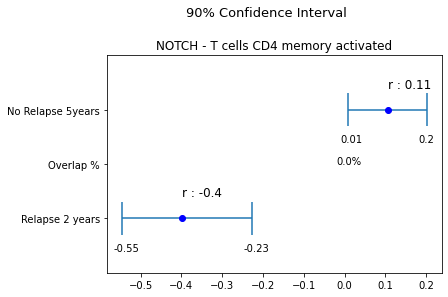

In [17]:
correlation.CI('NOTCH','T cells CD4 memory activated', show_info=False)

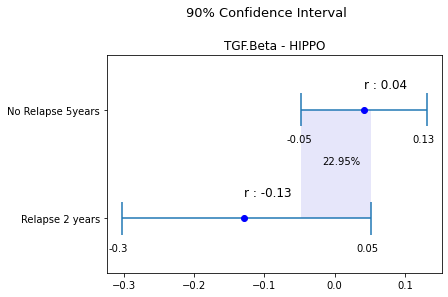

In [367]:
correlation.CI('TGF.Beta','HIPPO', show_info=False)